In [3]:
import quantopian.optimize as opt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import SimpleMovingAverage

from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.experimental import risk_loading_pipeline

from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import factset, USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.factors import Returns, SimpleMovingAverage, CustomFactor, RSI
from quantopian.pipeline.data import EquityPricing

from alphalens.performance import mean_information_coefficient
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_information_tear_sheet, create_returns_tear_sheet

In [4]:
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

MAX_SHORT_POSITION_SIZE = 1.0 / TOTAL_POSITIONS
MAX_LONG_POSITION_SIZE = 1.0 / TOTAL_POSITIONS


In [19]:
def make_pipeline():
    """
    A function that creates and returns our pipeline.
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation. In particular, this function can be
    copy/pasted into research and run by itself.
    Returns
    -------
    pipe : Pipeline
        Represents computation we would like to perform on the assets that make
        it through the pipeline screen.
    """
    # The factors we create here are based on fundamentals data and a moving
    # average of sentiment data
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
        )
    
    mean_close_3 = SimpleMovingAverage(
        inputs=[EquityPricing.close],
        window_length=3,
        )
    
    mean_close_200 = SimpleMovingAverage(
        inputs=[EquityPricing.close],
        window_length=200,
        )
    
    assets_turnover = SimpleMovingAverage(
            inputs = [Fundamentals.assets_turnover],
            window_length=3,
        )
    
    gross_margin = SimpleMovingAverage(
            inputs = [Fundamentals.gross_margin],
            window_length=3
        )
    
    universe = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    
    mean_close_3_winsorized = mean_close_3.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    
    mean_close_200_winsorized = mean_close_200.winsorize(
       min_percentile=0.05,
       max_percentile=0.95     
        )
    
    assets_turnover_winsorized = assets_turnover.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    
    gross_margin_winsorized = gross_margin.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )

    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    combined_factor = (
        value_winsorized.zscore() +
        quality_winsorized.zscore() +
        sentiment_score_winsorized.zscore() +
        mean_close_3_winsorized.zscore() +
        mean_close_200_winsorized.zscore() +
        assets_turnover_winsorized.zscore() + 
        gross_margin_winsorized.zscore()
    )

    # Build Filters representing the top and bottom baskets of stocks by our
    # combined ranking system. We'll use these as our tradeable universe each
    # day.
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    # The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    factor_to_analyze = (combined_factor)
    
    sector = Sector()
    
    return Pipeline(
        columns = {'factor_to_analyze': factor_to_analyze, 'sector': sector},
        screen = QTradableStocksUS() & factor_to_analyze.notnull() & sector.notnull()
    )

factor_data = run_pipeline(make_pipeline(), '2019-11-8', '2020-5-8')
pricing_data = get_pricing(factor_data.index.levels[1], '2019-11-8', '2020-5-8', fields='open_price')

Dropped 12.8% entries from factor data: 12.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


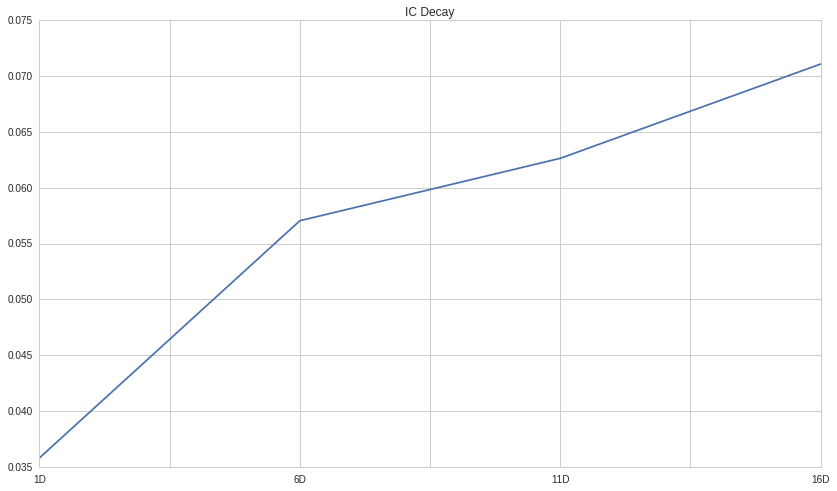

In [20]:
longest_look_forward_period = 21 # week = 5, month = 21, quarter = 63, year = 252
range_step = 5

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    periods = range(1, longest_look_forward_period, range_step)
)

mean_information_coefficient(merged_data).plot(title="IC Decay")

Dropped 8.1% entries from factor data: 8.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.026,0.034,0.041
IC Std.,0.118,0.140,0.128
Risk-Adjusted IC,0.217,0.245,0.323
t-stat(IC),2.327,2.632,3.461
p-value(IC),0.022,0.010,0.001
IC Skew,-0.202,-0.159,0.322
IC Kurtosis,-0.708,-0.405,-0.186


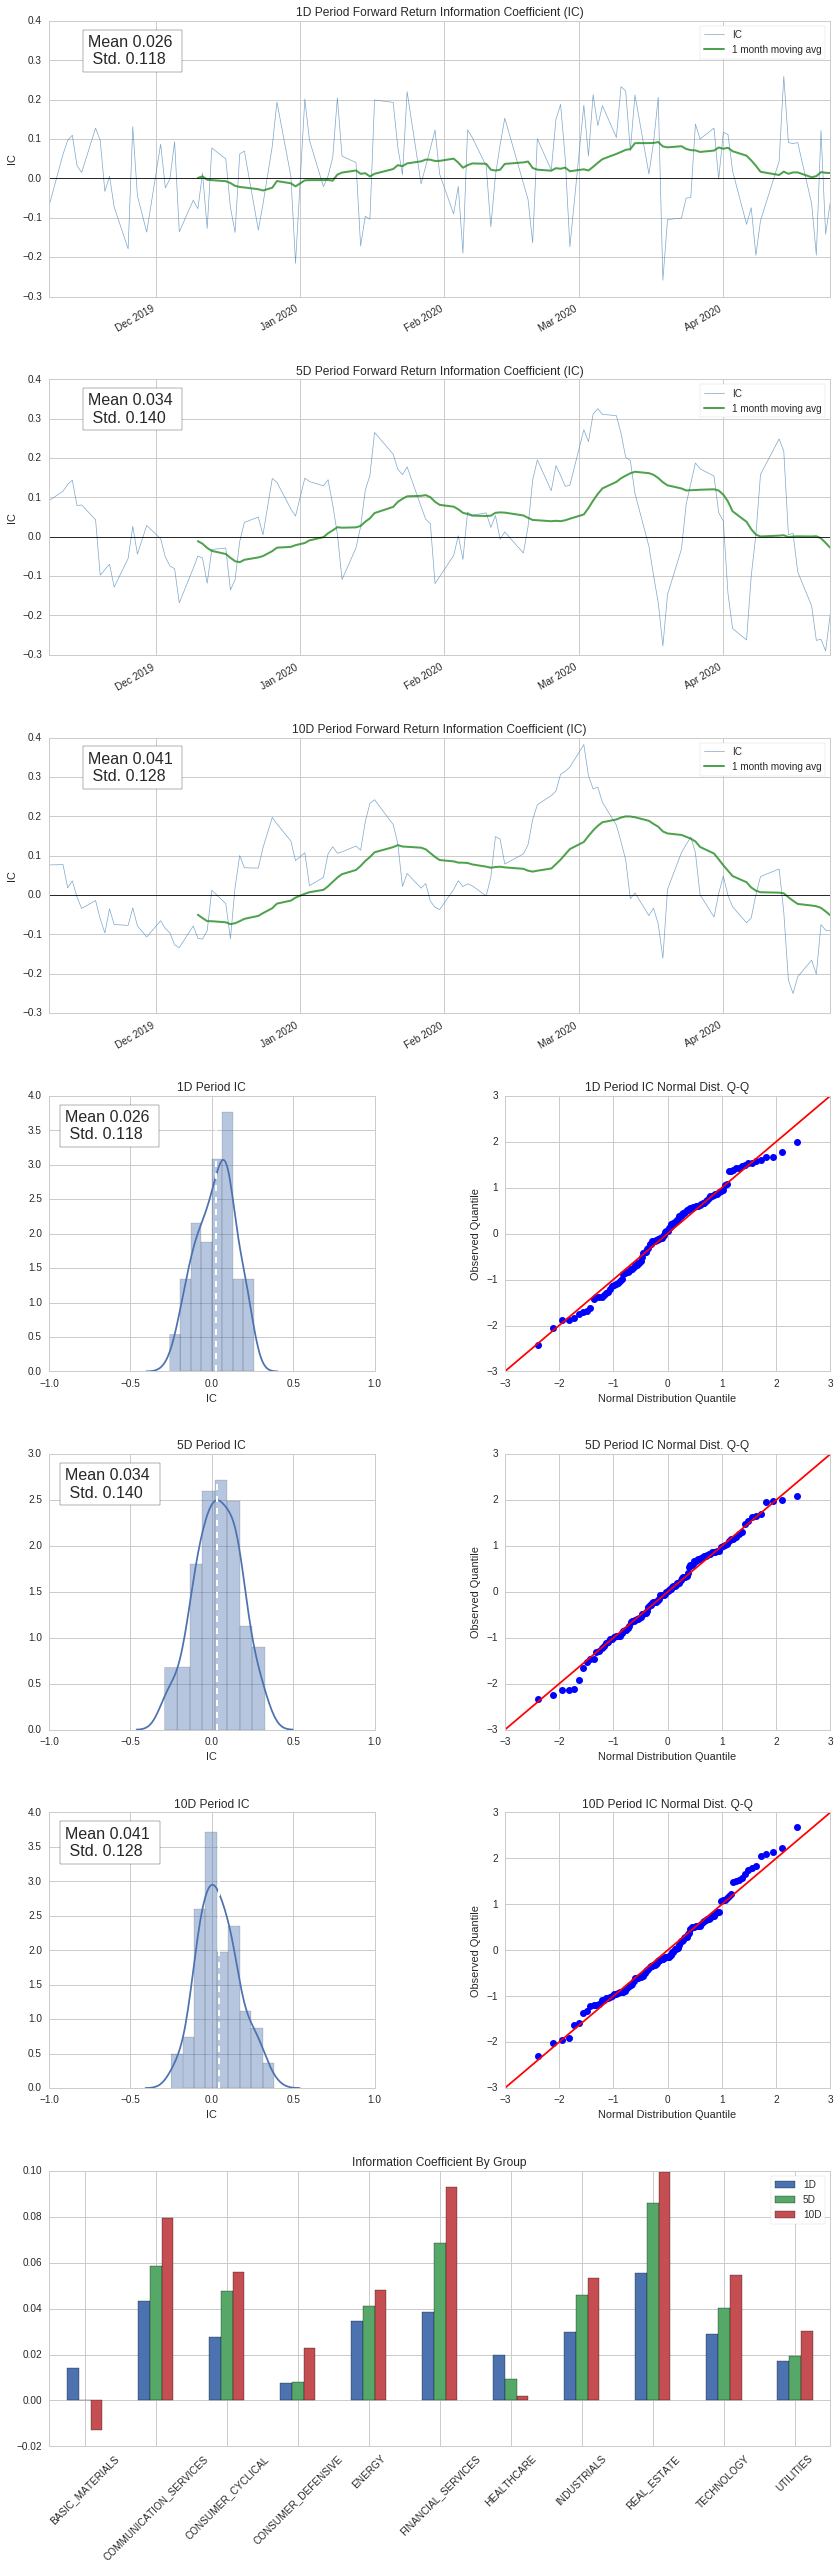

Returns Analysis


,1D,5D,10D
Ann. alpha,0.043,-0.009,0.022
beta,-0.157,-0.180,-0.131
Mean Period Wise Return Top Quantile (bps),7.292,3.503,4.528
Mean Period Wise Return Bottom Quantile (bps),-1.407,1.108,-0.914
Mean Period Wise Spread (bps),8.699,2.358,5.421


In [ ]:
sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

merged_data = get_clean_factor_and_forward_returns(
    factor = factor_data['factor_to_analyze'],
    prices = pricing_data,
    groupby = factor_data['sector'],
    groupby_labels = sector_labels,
    binning_by_group = True,
    periods = (1,5,10)
)

create_information_tear_sheet(merged_data, by_group=True, group_neutral=True)
create_returns_tear_sheet(merged_data, by_group=True, group_neutral=True)